# Main KernelPyLogit Example

The purpose of this Jupyter notebook is to demonstrate the key functionalities of PyKernelLogit by means of a real case study. Take into account that some of the functionalities described here are inherited from the original PyLogit package, especially those related with the estimation of conditional logit models. This example is divided in several parts.
1. Loading and preprocessing the data. This involves converting a dataframe between 'wide' and 'long' format.
2. Estimating a linear Random Utility model using a conditional logit model.
    1. Definition of a conditional logit model.
    2. Estimation of the previous model.
    3. Evaluation of the estimated model.
    4. Prediction using the estimated model.
    5. Computation of the Willingness to Pay (WTP) indicator using the estimated model.
3. Estimating a non-parametric model using Kernel Logistic Regression (KLR).
    1. Definition of a KLR model.
    2. Estimation of the previous KLR model.
    3. Evaluation of the estimated model.
    4. Prediction using the estimated model.
    5. Computation of the Willingness to Pay (WTP) indicator using estimated KLR model.


The dataset selected for this example is the 'Mode' dataset from the 'mlogit' package for R programming language (https://cran.r-project.org/web/packages/mlogit/mlogit.pdf). This dataset was elaborated by a project team in 'Discrete choice methods with simulation' (Train, 2003) and contains data about the mode choice of $453$ commuters. Each commuter has four available travel modes for their trips to work in a choice set $C=\{ \hbox{}bus, car, carpool, rail  \}$. The time and cost of travel for each mode were determined for each commuter. The attributes of the alternative $i \in C$ for the commuter $n$  are $x_{in}=(x_{in,cost}, x_{in,time})$ .


The first step is to load the different packages that will be used in this example.

In [1]:
from collections import OrderedDict    # For recording the model specification 

import pandas as pd                    # For file input/output
import numpy as np                     # For vectorized math operations

import PyKernelLogit as pkl            # For the estimation of the MNL and KLR models.

## 1. Loading and preprocessing the data

### 1.1. Load the data
The first step to estimate a model using PyKernelLogit is loading the dataset using a pandas dataframe.

In [2]:
# Load the Mode dataset from a .csv file. Nota that all the elements are delimited by a ',' character.
mode_choice = pd.read_csv("../data/ModeChoice.csv", sep=',')

# Show the first 5 rows of the data
mode_choice.head().T

,0,1,2,3,4
choice,car,rail,car,car,car
cost.car,1.50701,6.057,5.79468,1.86914,2.49895
cost.carpool,2.33561,2.89692,2.13745,2.57243,1.72201
cost.bus,1.80051,2.23713,2.57638,1.90352,2.686
cost.rail,2.35892,1.85545,2.74748,2.26828,2.97387
time.car,18.5032,31.3111,22.5474,26.0903,4.69914
time.carpool,26.3382,34.257,23.2552,29.896,12.4141
time.bus,20.8678,67.1819,63.3091,19.7527,43.092
time.rail,30.0335,60.2931,49.1716,13.4727,39.7433


### 1.2. Convert the dataset to long format

In order to estimate models using the PyKernelLogit library it is necessary to convert the data to "long" format.

Long format has 1 row per individual per available alternative, and wide format has 1 row per individual or observation. Long format is useful because it permits one to directly use matrix dot products to calculate the index, $V_{ij} = x_{ij} \beta$, for each individual $\left(i \right)$ for each alternative $\left(j \right)$. In situations where a dataset is provided in wide format (as in the case of the Mode dataset), it will be necessary to convert the data from wide format to long format.

To convert a dataset to long format, it is needed to specify:
<ol>
    <li>The variables or columns that are specific to a given individual, regardless of what alternative is being considered.</li>
    <li>The variables that vary across some or all alternatives, for a given individual (e.g. travel time).</li>
    <li>The availability variables.</li>
    <li>The <u>unique</u> observation id column.</li>
    <li>The choice column.</li>
</ol>

The following cells of code identify perform the necessary conversions from the wide to the long dataframe.


In [3]:
# Look at the columns of the Mode dataset
mode_choice.columns

Index(['choice', 'cost.car', 'cost.carpool', 'cost.bus', 'cost.rail',
       'time.car', 'time.carpool', 'time.bus', 'time.rail'],
      dtype='object')

In [4]:
# Convert choice from categorical variable to numeric one
mode_choice['choice'] = mode_choice['choice'].map({'car' : 1, 'carpool' : 2 , 'bus' : 3, 'rail' : 4})

# Create the list of individual specific variables
ind_variables = [] # There are no indivicual specific variables in this dataset

# Variables that vary across some or all alternatives, for a given individual
alt_varying_variables = {u'cost': dict([(1, 'cost.car'),
                                        (2, 'cost.carpool'),
                                        (3, 'cost.bus'),
                                        (4, 'cost.rail')]),
                         u'time': dict([(1, 'time.car'),
                                        (2, 'time.carpool'),
                                        (3, 'time.bus'),
                                        (4, 'time.rail')])
                        }

### Specify the availability variables
# Note that the keys of the dictionary are the alternative id's.
# The values are the columns denoting the availability for the
# given mode in the dataset. If the dataset does not contains any
# availability columns (such as in the Mode dataset), then the 
# keyword 'available_for_all' can be used to specify that an alternative
# is availables for all individuals.
availability_variables = {1: 'available_for_all',
                          2: 'available_for_all', 
                          3: 'available_for_all',
                          4: 'available_for_all'}

### Determine the columns for: alternative ids, the observation ids and the choice

# The 'custom_alt_id' is the name of a column to be created in the long format data
# It will identify the alternative associated with each row.
custom_alt_id = "mode_id"

# Create a custom id column. Note the +1 ensures the id's start at one.
obs_id_column = "custom_id"
mode_choice[obs_id_column] = np.arange(mode_choice.shape[0], dtype=int) + 1

# Create a variable recording the choice column
choice_column = "choice"

In [5]:
# Perform the conversion to long format
long_mode_choice = pkl.convert_wide_to_long(mode_choice, 
                                           ind_variables, 
                                           alt_varying_variables, 
                                           availability_variables, 
                                           obs_id_column, 
                                           choice_column,
                                           new_alt_id_name=custom_alt_id)

In [6]:
# Look at the resulting long format dataframe
long_mode_choice.head(10).T

,0,1,2,3,4,5,6,7,8,9
custom_id,1.00000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000
mode_id,1.00000,2.000000,3.000000,4.000000,1.000000,2.000000,3.000000,4.000000,1.000000,2.000000
choice,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
cost,1.50701,2.335612,1.800512,2.358920,6.056998,2.896919,2.237128,1.855451,5.794677,2.137454
time,18.50320,26.338233,20.867794,30.033469,31.311107,34.256956,67.181889,60.293126,22.547429,23.255171


### 1.3. Divide the final dataset into a train and test subsets

In machine learning it is a typical practise to divide the data into two sets: the training set and the test set. As these names imply, the model is trained using the training set, and then it is tested using the test set. This is commonly used to obtain the accuracy of the classifier on the new cases (the observations in the test set), which is called generalization error. This value indicates how well the model performs on instances it has never seen before. PyKernelLogit allows to divide a long format dataframe into a train and test subsets. 

In [7]:
# Define the percentaje of total observations which are used for training. 
train_size = 0.7

(train_set, test_set) = pkl.divide_long_train_test(long_mode_choice, train_size, obs_id_column)

## 2. Estimating a linear Random Utility model using a conditional logit model

Firstly, a linear Random Utility model using a conditional logit model will be estimated using the Mode dataset.

### 2.1. Definition of a conditional logit model

Before estimating a model, it is necessary to pre-compute all of the variables that are going to be used in the model. This is different from the functionalities of other package such as mlogit or statsmodels that use formula strings to create new variables. This is also somewhat different from Python Biogeme where new variables can be defined in the script but not actually created by the user before model estimation. PyKernelLogit (as it contains the same internal structure as PyLogit) does not perform variable creation. It only estimates models using variables that already exist.

For the Mode dataset no variable preprocessing was necessary. Moreover, it was decided not to scale any of the variables. No new variables have been defined either.

The first step is to create the model specification being used in this example:

$$
\begin{aligned}
V_{\textrm{Car}, n} &= \beta_{\textrm{travel cost}} \cdot \textrm{Cost}_{\textrm{Car}, n} + \\ 
        & \quad \beta_{\textrm{travel time}} \cdot \textrm{Time}_{\textrm{Car}, n} \\
        V_{\textrm{Carpool}, n} &= \textrm{ASC Carpool} + \\ 
        & \quad \beta_{\textrm{travel cost}} \cdot \textrm{Cost}_{\textrm{Carpool}, n} + \\ 
        & \quad \beta_{\textrm{travel time}} \cdot \textrm{Time}_{\textrm{Carpool}, n} \\
        V_{\textrm{Bus}, n} &= \textrm{ASC Bus} + \\ 
        & \quad \beta_{\textrm{travel cost}} \cdot \textrm{Cost}_{\textrm{Bus}, n} + \\ 
        & \quad \beta_{\textrm{travel time}} \cdot \textrm{Time}_{\textrm{Bus}, n} \\
        V_{\textrm{Rail}, n} &= \textrm{ASC Rail} + \\ 
        & \quad \beta_{\textrm{travel cost}} \cdot \textrm{Cost}_{\textrm{Rail}, n} + \\ 
        & \quad \beta_{\textrm{travel time}} \cdot \textrm{Time}_{\textrm{Rail}, n}
\end{aligned}
$$

Note that packages such as mlogit and statsmodels do not, by default, handle coefficients that vary over some alternatives but not all. PyKernelLogit does have this capability.

In order to specify a linear model in PyKernelLogit it is necessary to create two ordered dictionaries:

* Specification ordered dictionary. It contains the desired PyKernelLogit model specification. The dictionary keys should be variables within the long format dataframe (i.e. the column names from the dataframe), whereas, their associate value should be a list of integers, where the integers are the alternative ID's of the alternative whose utility specification the explanatory variable is entering. In other words, for each integer $i$ in the list, a $\beta_{ik}$ parameter is created, which multiplies the attribute $x_{ink}$ selected on the ordered dictionary key. It is also possible to use the same $\beta_{k}$ parameter for more than one alternative. In this case, a nested list should be added containing the alternative ID's of the alternatives that will share the common parameter.
    
* Variable names ordered dictionary. This order dictionary should contain the same keys that the Specification ordered dictionary. The value should be a list with the names for the $\beta_{k}$ parameters that will be estimated for each of the elements within the outer-most list on the Specification ordered dictionary.


The keys of both ordered dictionaries should be variables from the long format dataframe with the sole exception of the intercept key. The value associated with this key is a list with the alternative ID's for which an intercept will be added in the model specification.

In [8]:
# Create an empty basic_specification and basic_names ordered dictionary
basic_specification = OrderedDict()
basic_names = OrderedDict()

# Model specification
basic_specification["intercept"] = [2, 3, 4]
basic_names["intercept"] = ['ASC CarPool',
                            'ASC Bus',
                            'ASC Rail']

basic_specification["cost"] = [[1, 2, 3, 4]]
basic_names["cost"] = ['Travel cost (dollars)']

basic_specification["time"] = [[1, 2, 3, 4]]
basic_names["time"] = ['Travel time (minutes)']

### 2.2. Estimation of the previous model

Once the model has been specified, it is necessary to estimate its parameters. PyKernelLogit allows to estimate the previous model using Maximum Likelihood Estimation (MLE) or Penalized Maximum Likelihood Estimation (PMLE). In this example, as the model is not complex, MLE is used.

In [9]:
# Estimate the multinomial logit model (MNL)
linear_model = pkl.create_choice_model(data=train_set,
                                           alt_id_col=custom_alt_id,
                                           obs_id_col=obs_id_column,
                                           choice_col=choice_column,
                                           specification=basic_specification,
                                           model_type="MNL",
                                           names=basic_names)

The previous model can be estimated using the fit_mle() method. This method is designed to estimate Multinomial Logit Models and receives several parameters: 
* init_vals. The initial values of $\boldsymbol{\beta}$ (RUM) or $\boldsymbol{\alpha}$ (KLR) to start the optimization process with. It should be a vector with one value for each utility coefficient being estimated.

* method. It should be a valid string that can be passed to scipy.optimize.minimize. Determines the optimization algorithm that is used for this problem. The default newton-cg which uses the Newton-CG algorithm.

* PMLE. It determines if a Penalized Maximum Likelihood Estimation should be executed. The value of the parameter determines the type of PMLE and the possible values are LASSO and RIDGE.

* PMLE_lambda. Lambda parameter for LASSO or ridge regression. It should be an int, float or long and determines the penalty parameter for the PMLE.



In [10]:
# Fit the linear model using MLE
linear_model.fit_mle(np.zeros(5), method='BFGS')

Log-likelihood at zero: -439.4553
Initial Log-likelihood: -439.4553
Estimation Time for Point Estimation: 0.01 seconds.
Final log-likelihood: -249.6988


### 2.3. Evaluation of the estimated model

Once the model has been estimated, the next step is to asses the performance of the model.

In machine learning, there are several alternatives for assessing whether a model is good enough for the specific application for which the model is going to be used. The goodness of fit of a model is a statistic which descries how well a model, with its estimated parameters, performs compared with a model in which all its parameters are zero (which is usually equivalent to having no model at all, i.e. in the discrete choice context is equivalent to a model for which the probability of choosing an alternative is the same for all the alternatives). This comparison is made using the log-likelihood function, which is evaluated at both models, one with estimated parameters and other with all its parameters equal zero. The likelihood ratio index (also called McFadden R square) is defined as:
\begin{equation}
    \label{eq:ro-square}
    \rho^2 = 1-\frac{LL(\hat{\boldsymbol{\beta}})}{LL(\boldsymbol{0})}.
\end{equation}

This measure has been derived to mimic the $R^2$ used in linear regression, but in this case its interpretation is not similar at all. If the estimated model has the same log-likelihood as an equal probability model, then $\rho^2 = 0$. On the contrary, if the estimated model perfectly fits the data ($LL(\hat{\boldsymbol{\beta}}) = 0$), then $\rho^2 = 1$. This value, unlike $R^2$, cannot be interpreted, and it must only be used to compare between two models estimated using the same sample. For this reason, two models estimated on different samples cannot be compared via their likelihood ratio index values.

It presents another disadvantage because this measure is monotonic in the number of parameters of the model, which means that this index increase each time an additional variable is added to the model, even if it does not explain anything. There is a variant of the $\rho^2$ index which offer a corrected measure:
\begin{equation}
    \label{eq:pseudo-ro-bar-square}
    \overline{\rho}^{2} = 1-\frac{LL(\hat{\boldsymbol{\beta}})-\nu}{LL(0)},
\end{equation}
where $\nu$ is the number of parameters in the model.

When a model is estimated, PyKernelLogit allows to obtain a summary of the results by using the function get_statsmodels_summary. This function integrates both, $\rho^2$ and $\overline{\rho}^{2}$ goodness of fit measures, which are called here as Pseudo R-squ. and Pseudo R-bar-squ., respectively.

In [11]:
# Obtain a summary of the results for the linear model
linear_model.get_statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                  317
Model:             Multinomial Logit Model   Df Residuals:                      312
Method:                                MLE   Df Model:                            5
Date:                     Fri, 28 Feb 2020   Pseudo R-squ.:                   0.432
Time:                             14:15:35   Pseudo R-bar-squ.:               0.420
AIC:                               509.398   Log-Likelihood:               -249.699
BIC:                               528.192   LL-Null:                      -439.455
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ASC CarPool              -4.1890      0.470     -8.915      0.000      -5.110      -3.268
ASC Bus                  -3.4403      0.390     -8.819      0.000      -4.205      -2.676
ASC Rail                 -2.7398      0.354     -7.745      0.000      -3.433      -2.046
Travel cost (dollars)    -0.7903      0.112     -7.077      0.000      -1.009      -0.571
Travel time (minutes)    -0.0829      0.009     -9.051      0.000      -0.101      -0.065
=========================================================================================
"""

These goodness of fit measures cannot measure how the model predict on new data points, for which it has not yet seen the true value of the dependent variable (the alternative chosen). Therefore, some other model validation techniques are available on the PyKernelLogit package.

A much better way to evaluate the performance of a classifier is to look at the so-called confusion matrix. The idea is to count the number of instances of class A which are classified as class B. The confusion matrix can be computed as follows.

In [12]:
# Compute the confunsion matrix using the test set
confusion_matrix = linear_model.confusion_matrix(test_set)

# The generated confusion matrix can be shown directly as a pandas dataframe
confusion_matrix

,1,2,3,4
1,56,3,2,3
2,3,0,0,4
3,8,0,9,9
4,11,0,5,23


Text(0.5, 1, 'Confusion Matrix')

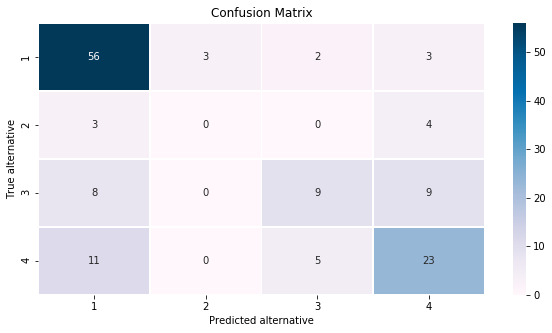

In [13]:
# Another option is to use the heatmap method of the seaborn package to 
# visualize the confusion matrix. This generates more elegant ilustrations.

%matplotlib inline

# Import seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt     

# Generate a new figure and set the figure size.
plt.figure(figsize=(10,5))

# Generate a heatmap for the confusion matrix using seaborn
ax = sns.heatmap(confusion_matrix, annot=True, linewidth=0.5, cmap='PuBu')

# labels, title and ticks
ax.set_xlabel('Predicted alternative')
ax.set_ylabel('True alternative')
ax.set_title('Confusion Matrix')

# Figures can be stored as images by means of ax.figure.savefig() method.

As it is shown, the confusion matrix gives lot of useful information, but sometimes it is preferred a more concise metric. An other interesting way of assessing the performance of a model is to look the accuracy of the positive predictions, which is called the precision. 

This metric has an important drawback because if the model makes a single positive prediction and it is correct, then the precision will be 1/1 = 100\%. This results would not be useful since the classifier would ignore all the predictions except for the only one positive instance. For that reason, the precision metric is commonly used along with another metric called recall, or sensitivity. The recall is the ratio of positive instances that are correctly detected by the classifier. 

Finally, there is a third metric called F-score, which combines the precision and the recall results to compute the score. The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0. The $\beta$ parameter determines the weight of recall in the combined score. When $\beta < 1$, the F-score lends more weight to precision, while $\beta > 1$ favors recall. Moreover, $\beta \rightarrow 0$ considers only the precision and $\beta \rightarrow \infty$ only the recall.

This metrics can be applied directly to problems where only two alternatives are considered. For problems with more than two alternatives an averaging technique should be applied. PyKernelLogit offers two averaging techniques:
* Macro-averaging.
* Micro-averaging. 

The precision, recall and F-score metrics can be computed for the previous model using the following command.

In [14]:
# Compute the precision, recall and F1-score for the linear model using a
# Micro-averaging technique. The F1-score is the F-score for beta = 1.
linear_model.precision_recall_fscore(test_set, "micro", beta = 1)

(0.6470588235294118, 0.6470588235294118, 0.6470588235294118)

### 2.4. Prediction using the estimated model

Once the model has been estimated, new instances can be predicted using the model. The next block of code shows how to create a pandas dataframe which contains a matrix with the probabilities predicted for each alternative for a given observation.

In [15]:
# The different observations from the test_set are represented on each row.
# The columns represent each of the alternatives. The value from each cell
# is the probability that the alternative on the corresponding column was
# selected on that observation.
pd.DataFrame(data=linear_model.predict(test_set).reshape(-1, 4))

,0,1,2,3
0,0.963694,0.003965,0.020135,0.012206
1,0.838091,0.005317,0.044212,0.112380
2,0.981976,0.014513,0.001126,0.002385
3,0.590096,0.086270,0.042587,0.281048
4,0.148308,0.019157,0.082536,0.749999
...,...,...,...,...
131,0.216609,0.103513,0.087728,0.592150
132,0.777684,0.017586,0.056032,0.148698
133,0.781351,0.117042,0.066393,0.035214
134,0.767810,0.031292,0.009875,0.191023


### 2.5. Computation of the Willingness to Pay (WTP) indicator using the estimated model

There are many indicators that are particularly relevant in the context of discrete choice models, such as, Willingness to Pay (WTP) and the Value of Time (VOT). If the estimated model contains a cost or price variable, which indicates the total cost of the alternative for a given decision-maker, it is possible to analyze the trade-off between any other variable form the model and money. This trade-off reflects the **willingness of the decision-maker to pay** for a modification of one unit of another variable of the model.

Lets consider that $c_{in}$ is the cost of the alternative $i$ for a decision-maker $n$, and $x_{in}$ is the value of another variable. Now, let $V_{in}(c_{in}, x_{in})$ be the value of the utility function that is associated to an alternative $i$ for a decision-maker $n$. It can be considered a scenario where the variable under interest takes the value $x_{in} + \delta^{x}_{in}$, where $\delta^{x}_{in}$ is an increment over the value of the $x$ variable. It is denoted by $\delta^{c}_{in}$ the additional cost increment that would be necessary to achieve the same utility as if no increment were made over $x$ variable, that is
\begin{equation}
    \label{eq:WTP-same-utility}
    V_{i n}\left(c_{i n}+\delta_{i n}^{c}, x_{i n}+\delta_{i n}^{x}\right)=V_{i n}\left(c_{i n}, x_{i n}\right).
\end{equation}

If $x_{in}$ and $c_{in}$ appear linearly in the utility function, that is if 
$V_{i n}\left(c_{i n}, x_{i n}\right)=\beta_{c} c_{i n}+\beta_{x} x_{i n}+\cdots$
Then, the WTP can be calculated directly using the coefficients ratio as:
\begin{equation}
    WTP = \frac{\delta_{i n}^{c}}{\delta_{i n}^{x}}=-\frac{\left(\partial V_{i n} / \partial x_{i n}\right)\left(c_{i n}, x_{i n}\right)}{\left(\partial V_{i n} / \partial c_{i n}\right)\left(c_{i n}, x_{i n}\right)}=-\frac{\beta_{x}}{\beta_{c}}
\end{equation}
where $\beta_{c}$ is the calculated coefficient for the cost.

The above equation is the willingness to pay for an increase of the value of
the variable $x_{in}$. Therefore, if this increase improves the utility of the alternative, then $\beta_{x}>0$.


Another concept is the **Value of Time (VOT)**, which is closely related with the previous one, as it reflects the price that a traveler is willing to pay to decrease the travel time in one unit. Hence, the formula for the VOT is:
\begin{equation}
    \mathrm{VOT}_{i n}=\delta_{i n}^{c} /\left(-\delta_{i n}^{t}\right)=\frac{\left(\partial V_{i n} / \partial t_{i n}\right)\left(c_{i n}, t_{i n}\right)}{\left(\partial V_{i n} / \partial c_{i n}\right)\left(c_{i n}, t_{i n}\right)}
\end{equation}

As $V$ is linear in the cost and time parameters, we have
\begin{equation}
    \mathrm{VOT}_{i n}=\delta_{i n}^{c} /\left(-\delta_{i n}^{t}\right)=\frac{\beta_{t}}{\beta_{c}}
\end{equation}


In this example, it is interesting to compute the **VOT** as the model contains the cost and time variables.

In [16]:
# To compute the VOT for the linear model, we need to apply the previous equation.
# Take into account that travel time is in minutes, therefore beta_t = 1/minutes,
# which is equal as beta_t = 60 * 1/hours. Now, VOT is measured in dollars/hours.

(linear_model.coefs['Travel time (minutes)']*60) / linear_model.coefs['Travel cost (dollars)']

6.293743644982097

## 3. Estimating a non-parametric model using Kernel Logistic Regression (KLR)

Now, a non-parametric model is estimated using KLR capabilities from PyKernelLogit.

### 3.1. Definition of a KLR model

The first step is to consider if the data should be preprocessed. It is a good practice to scale the data before a KLR model is applied. Skcikit-learn Python package can be used to scale the data.

In [17]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train_set[['cost', 'time']])

train_set_scaled = train_set.copy()
train_set_scaled[['cost', 'time']] = scaler.transform(train_set[['cost', 'time']])

test_set_scaled = test_set.copy()
test_set_scaled[['cost', 'time']] = scaler.transform(test_set[['cost', 'time']])

The following step to define a KLR model is to compute the kernel matrix, or Gram matrix, using the input dataframe. The kernel_matrix function returns a list composed of one kernel matrix $\mathbf{K}^{(i)}$ per alternative $i$. This function takes the following input values:
* X. The dataset in long format for which the kernel matrix is computed, i.e. $\mathbf{X}_{i}$. 

* alt_id_col. The name for the alternative ID column in the long dataframe.

* obs_id_col. The column from the wide dataset that contains the ID of each observation.

* variables. A Python dictionary where each key represents each of the alternatives IDs and its associated value contains a list of characteristics from the long dataframe X to be used on that alternative.

* kernel_type. The type of kernel function to be used. The kernel_matrix function relies on the scikit-learn Python package for the kernel functions. The value passed on the kernel_type parameter specifies the scikit-learn kernel function which is going to be used to compute the kernel matrix.

* Z. The kernel_matrix function also allows the user to specify a reference matrix $\mathbf{Z}_{i}$ to be used when computing the kernel matrix. If no Z dataframe is specified, then the kernel matrix is computed taking as reference matrix the input matrix X.

* \*\*kernel\_kwargs. Keyworded variable length of arguments to be provided to the invoked scikit-learn kernel function.

In [18]:
variables = {1: ['cost', 'time'],
             2: ['cost', 'time'],
             3: ['cost', 'time'],
             4: ['cost', 'time']}



K_long_format_train = pkl.long_format_with_kernel_matrix(train_set_scaled, 
                                                         custom_alt_id, 
                                                         obs_id_column, 
                                                         choice_column, 
                                                         variables, 
                                                         kernel_type = "RBF")

The next step is to define the KLR model specification. Similarly to the linear model specification, it is necessary to create two ordered dictionaries:
* Specification ordered dictionary.
* Variable names ordered dictionary.

The PyKernelLogit function define_kernel_specification generates automatically the specification and variable names ordered dictionaries for the desired kernel model using the specification attributes provided through its input parameters:
* K_long_format. A long format dataframe that contains the kernel matrix for all the alternatives in the dataset. This dataframe should be obtained using the long_format_with_kernel_matrix function.

* alt_id_col. The name for the alternative ID column in the long dataframe.

* obs_id_col. The column from the wide dataset that contains the ID of each observation.

* specification. A previously defined specification ordered dictionary where the kernel logistic model specification will be inserted. It is recommended to pass an empty ordered dictionary.

* names. A previously defined variable names ordered dictionary where it will be inserted the names for the $\boldsymbol{\alpha}_i$ parameters to be estimated. It is recommended to pass an empty ordered dictionary.

* alpha_per_alternative. A boolean variable. If this this variable is True then one vector of parameters to estimate $\boldsymbol{\alpha}_i$ is used per alternative $i$. Otherwise, the same vector of parameters $\boldsymbol{\alpha}$ is used for all the alternatives. This generates a more restricted model, but this model will have much less parameters to be estimated. The default value is False.

* intercept. If this parameter is None (the default value), then no intercept parameter is added to the model. If this parameter contains an integer value, then an intercept parameter is added to the model. The intercept parameter must be the alternative ID of the alternative selected to be the reference alternative. No intercept is generated for the reference alternative because it is considered to be zero.

This method returns a tuple with 3 elements: the basic_specification and basic_names ordered dictionaries and the total number of variables to be estimated in the model.

The following code fragment is used to define the basic_specification and basic_names ordered dictionaries for a KLR model with the same $\boldsymbol{\alpha}$ vector of parameters for all the alternatives and an intercept parameter.


In [19]:
[basic_specification, basic_names, total_vars] = pkl.define_kernel_specification(K_long_format_train, 
                                                                                 custom_alt_id,
                                                                                 obs_id_column,
                                                                                 specification=OrderedDict(),
                                                                                 names=OrderedDict(),
                                                                                 alpha_per_alternative=False,
                                                                                 intercept=1)

### 3.2. Estimation of the previous KLR model

Once the KLR model has been specified, it is necessary to estimate its parameters in a similar way that the previous linear model.

In [20]:
# Estimate the multinomial logit model (MNL)
kernel_model = pkl.create_choice_model(data=K_long_format_train,
                                       alt_id_col=custom_alt_id,
                                       obs_id_col=obs_id_column,
                                       choice_col=choice_column,
                                       specification=basic_specification,
                                       model_type="MNL",
                                       names=basic_names)

The previous model can be also estimated using the fit_mle() method. Now, instead of using Maximum Likelihood Estimation (MLE), it was decided to use Penalized Maximum Likelihood Estimation (PMLE) due to the high number of parameters. It was decided to use a Ridge regression with a penalty parameter $\lambda$ = 4. Moreover,  L-BFGS-B optimization method was used to estimate the parameters because, although it obtains slightly worse results than BFGS method, the parameters are estimated remarkably fast as it is designed to optimize a large number of parameters using a limited amount of memory.

In [21]:
# Specify the initial values and method for the optimization.
kernel_model.fit_mle(np.zeros(total_vars), method="L-BFGS-B", PMLE="RIDGE", PMLE_lambda=4)

Log-likelihood at zero: -439.4553
Initial Log-likelihood: -439.4553
Estimation Time for Point Estimation: 0.03 seconds.
Final log-likelihood: -277.9502


/home/joseangel/.local/lib/python3.6/site-packages/PyKernelLogit/conditional_logit.py:376: UserWarning: NOTE: A penalized regression is being performed. The reported standard errors and robust standard errors ***WILL BE INCORRECT***.
  warnings.warn(_ridge_warning_msg)
/home/joseangel/.local/lib/python3.6/site-packages/PyKernelLogit/base_multinomial_cm_v2.py:1231: RuntimeWarning: invalid value encountered in sqrt
  self._store_inferential_results(np.sqrt(np.diag(self.cov)),
/home/joseangel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/joseangel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/joseangel/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### 3.3. Evaluation of the estimated model

Once the model has been estimated, the performance of the model can be assessed such as in the linear model. Therefore, get_statsmodels_summary() can be used to obtain the goodness of fit of the model and the estimated parameters.

In [22]:
# Look at the estimation results
kernel_model.get_statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                  317
Model:             Multinomial Logit Model   Df Residuals:                       -3
Method:                                MLE   Df Model:                          320
Date:                     Fri, 28 Feb 2020   Pseudo R-squ.:                   0.368
Time:                             14:15:37   Pseudo R-bar-squ.:              -0.361
AIC:                             1,195.900   Log-Likelihood:               -277.950
BIC:                             2,398.749   LL-Null:                      -439.455
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ASC 2         -0.7932    843.246     -0.001      0.999   -1653.526    1651.939
ASC 3         -0.5352    925.261     -0.001      1.000   -1814.013    1812.942
ASC 4         -0.0256    827.401   -3.1e-05      1.000   -1621.702    1621.651
alpha_1       -0.1119        nan        nan        nan         nan         nan
alpha_2       -0.0724        nan        nan        nan         nan         nan
alpha_3        0.1261        nan        nan        nan         nan         nan
alpha_4        0.0074   1.33e+06   5.59e-09      1.000   -2.61e+06    2.61e+06
alpha_5        0.0525        nan        nan        nan         nan         nan
alpha_6        0.0348    9.4e+06    3.7e-09      1.000   -1.84e+07    1.84e+07
alpha_7       -0.0053   7.93e+06  -6.67e-10      1.000   -1.55e+07    1.55e+07
alpha_8       -0.1580        nan        nan        nan         nan         nan
alpha_9       -0.0290    3.9e+06  -7.44e-09      1.000   -7.64e+06    7.64e+06
alpha_10      -0.2071   5.64e+06  -3.67e-08      1.000   -1.11e+07    1.11e+07
alpha_11       0.0867   5.19e+06   1.67e-08      1.000   -1.02e+07    1.02e+07
alpha_12       0.1213   7.52e+05   1.61e-07      1.000   -1.47e+06    1.47e+06
alpha_13       0.0644   8.12e+06   7.94e-09      1.000   -1.59e+07    1.59e+07
alpha_14       0.2021   9.17e+05    2.2e-07      1.000    -1.8e+06     1.8e+06
alpha_15       0.0202   9.52e+06   2.12e-09      1.000   -1.87e+07    1.87e+07
alpha_16      -0.0955   9.07e+06  -1.05e-08      1.000   -1.78e+07    1.78e+07
alpha_17       0.0715        nan        nan        nan         nan         nan
alpha_18      -0.1768   6.45e+06  -2.74e-08      1.000   -1.26e+07    1.26e+07
alpha_19      -0.0726        nan        nan        nan         nan         nan
alpha_20      -0.1114   3.35e+06  -3.33e-08      1.000   -6.56e+06    6.56e+06
alpha_21       0.0443   7.08e+06   6.25e-09      1.000   -1.39e+07    1.39e+07
alpha_22      -0.0446    1.6e+06  -2.79e-08      1.000   -3.14e+06    3.14e+06
alpha_23      -0.0163        nan        nan        nan         nan         nan
alpha_24       0.0758   3.61e+06    2.1e-08      1.000   -7.07e+06    7.07e+06
alpha_25       0.0586   3.68e+06   1.59e-08      1.000   -7.22e+06    7.22e+06
alpha_26      -0.0488        nan        nan        nan         nan         nan
alpha_27      -0.1262   4.75e+06  -2.66e-08      1.000   -9.31e+06    9.31e+06
alpha_28       0.0352   4.83e+06   7.29e-09      1.000   -9.47e+06    9.47e+06
alpha_29      -0.0126   7.15e+06  -1.76e-09      1.000    -1.4e+07     1.4e+07
alpha_30       0.1004    7.1e+06   1.42e-08      1.000   -1.39e+07    1.39e+07
alpha_31       0.1157   2.27e+06   5.09e-08      1.000   -4.45e+06    4.45e+06
alpha_32      -0.0167        nan        nan        nan         nan         nan
alpha_33      -0.2332   3.58e+06  -6.51e-08      1.000   -7.01e+06    7.01e+06
alpha_34      -0.1810        nan        nan        nan         nan         nan
alpha_35       0.0023   2.79e+06   8

It is more interesting to compute the confusion matrix and the precision, recall and F-score metric such as in the previous model. Nonetheless, the first step must be to compute the long format kernel matrix for the test set that is necessary to compute the previous metrics using KLR. This can be done using the following code.

In [23]:
# Comute the long format kernel matrix for the test set.
K_long_format_test = pkl.long_format_with_kernel_matrix(test_set_scaled, 
                                                        custom_alt_id, 
                                                        obs_id_column, 
                                                        choice_column, 
                                                        variables, 
                                                        kernel_type = "RBF", 
                                                        Z = train_set_scaled,
                                                        length_scale = 1)

In [24]:
# Compute the confunsion matrix using the test set
confusion_matrix = kernel_model.confusion_matrix(K_long_format_test)

# The generated confusion matrix can be shown directly as a pandas dataframe
confusion_matrix

,1,2,3,4
1,57,0,0,7
2,3,0,0,4
3,7,0,11,8
4,8,0,6,25


Text(0.5, 1, 'Confusion Matrix')

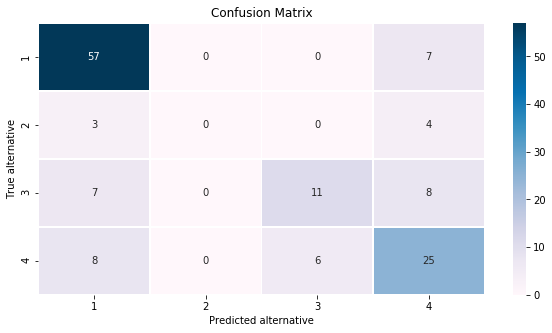

In [25]:
# Visualize the confusion matrix using seaborn.
# Generate a new figure and set the figure size.
plt.figure(figsize=(10,5))

# Generate a heatmap for the confusion matrix using seaborn
ax = sns.heatmap(confusion_matrix, annot=True, linewidth=0.5, cmap='PuBu')

# labels, title and ticks
ax.set_xlabel('Predicted alternative')
ax.set_ylabel('True alternative')
ax.set_title('Confusion Matrix')

In [26]:
# Compute the precision, recall and F1-score for the linear model using a
# Micro-averaging technique. The F1-score is the F-score for beta = 1.
kernel_model.precision_recall_fscore(K_long_format_test, "micro", beta = 1)

(0.6838235294117647, 0.6838235294117647, 0.6838235294117647)

### 3.4. Prediction using the estimated model

Again, once the model has been estimated, new instances can be predicted using the model.

In [27]:
# The different observations from the test_set are represented on each row.
# The columns represent each of the alternatives. The value from each cell
# is the probability that the alternative on the corresponding column was
# selected on that observation.
pd.DataFrame(data=kernel_model.predict(K_long_format_test).reshape(-1, 4))

,0,1,2,3
0,0.916604,0.017250,0.040786,0.025359
1,0.739171,0.024550,0.082291,0.153987
2,0.953754,0.033085,0.004249,0.008912
3,0.314859,0.203336,0.105414,0.376390
4,0.149059,0.049907,0.112112,0.688923
...,...,...,...,...
131,0.217392,0.137808,0.116807,0.527993
132,0.612135,0.105613,0.090062,0.192190
133,0.764801,0.114906,0.084024,0.036269
134,0.660301,0.128328,0.030257,0.181114


### 3.5. Computation of the Willingness to Pay (WTP) indicator using the estimated KLR model

As shown previously, the equation to compute the WTP is:
\begin{equation}
    WTP = \frac{\delta_{i n}^{c}}{\delta_{i n}^{x}}=-\frac{\left(\partial V_{i n} / \partial x_{i n}\right)\left(c_{i n}, x_{i n}\right)}{\left(\partial V_{i n} / \partial c_{i n}\right)\left(c_{i n}, x_{i n}\right)}
\end{equation}
where $c_{in}$ is the cost of the alternative $i$ for a decision-maker $n$ and $x_{in}$ is the value of another variable from the model. The WTP can be computed directly using a close expression for the linear RUM (as shown in section 2.5, nonetheless, for the KLR models it is necessary to compute the gradient vector of the partial derivatives of the systematic utility function. 

Since KLR is a non-linear model, the first step is to define the point where the WTP is going to be computed. Any observation from a long format dataframe can be selected as this WTP point and, therefore, the WTP for that decision-maker can be computed. Moreover, the analyst can use any point for the WTP calculation, but this point should be provided in a long format dataframe.

The following lines of code shows how to compute the WTP for any observation from the dataframe using KLR. The first step is to select the WTP point.

In [28]:
# Compute the WTP of any observation from the dataframe
WTP_point = long_mode_choice.loc[long_mode_choice[obs_id_column] == 12]

WTP_point

,custom_id,mode_id,choice,cost,time
44,12,1,1,1.864544,17.530151
45,12,2,0,0.568055,26.731061
46,12,3,0,2.167807,55.347093
47,12,4,0,1.978343,32.651246


Next, the PyKernelLogit function calculate_WTP_kernel can be used to calculate the WTP indicador for an observation using KLR by numerically approximating the gradient vector of the systematic utility. This function takes following input arguments:
* WTP_cost_column. Column name with contains the cost or price of the alternative.

* WTP_x_column. Column name with contains the variable to be analyzed.

* alt. Indicates the alternative for which the WTP is computed.

* model. A MNDC_Model instance corresponding with the trained model.

* variables. A Python dictionary where each key represents each of the alternatives IDs and its associated value contains a list of characteristics from the long dataframe WTP_point and Z to be used on that alternative.

* WTP_point. A dataframe in long format with only one observation (1 row per each alternative of that observation) for which the Willingness to Pay is going to be computed.

* Z. A reference matrix $\mathbf{Z}_{i}$ to be used when computing the kernel matrix.

* kernel_type. The type of kernel function to be used.

* scaler. If none scaler was used to fit the kernel model, this parameter must be None. Otherwise, an instance of the scaler function must be provided here. The provided scaler must contain a transform function which scale the features of the dataset according to the scaler definition.

* epsilon. The $\varepsilon$ parameter. The increment of the coordinate vector used for determining the function gradient.  

As it was described previously the Value of time (VOT) reflects the price that a traveler is willing to pay to decrease the travel time in one unit. In this example, it is interesting to compute the **VOT** as the model contains the cost and time variables.


In [29]:
# Comuthe the VOT for a KLR model, i.e. the WTP using cost an time variables.
# Take into account that travel time is in minutes, therefore, the VOT must be
# multiplied by 60 to convert it to hours.
VOT = -60 * pkl.calculate_WTP_kernel(WTP_cost_column = 'cost', 
                                    WTP_x_column = 'time', 
                                    alt = 1, 
                                    model = kernel_model, 
                                    variables = variables, 
                                    WTP_point = WTP_point, 
                                    Z = train_set_scaled, 
                                    kernel_type = "RBF", 
                                    scaler = scaler,
                                    scaled_fetures=['cost', 'time'])

VOT

7.617601618103002

The analyst can evalute the WTP also for an hypothetical observation which is not present at the dataframe, but this point should be provided in a long format dataframe. In this case, the obs_id_col, alt_id_col and choice_col must be created by the user manually. To illustrate this concept, the following code computes the WTP for an observation for which the value of each variable is the mean value of that variable in the Mode dataframe.

In [30]:
# Define the WTP_points columns. 
WTP_point_columns = [obs_id_column, custom_alt_id, choice_column, 'cost', 'time']
WTP_point = pd.DataFrame(columns=WTP_point_columns)

# Append to WTP_points dataframe the mean value for each dataframe variable
WTP_point = WTP_point.append({ obs_id_column: 1, # Fixed to 1, necessary to create a long type dataframe
                               choice_column: 1, # Fixed to 1 in the first alternative. Necessary to create a long type dataframe
                               custom_alt_id: 1, # It indicates the alternative for which the data is stored
                               'cost': mode_choice['cost.car'].mean(),
                               'time': mode_choice['time.car'].mean(),
                               }, ignore_index=True)
WTP_point = WTP_point.append({ obs_id_column: 1, # Fixed to 1, necessary to create a long type dataframe
                               choice_column: 0, # Fixed to 0 in the rest of alternatives
                               custom_alt_id: 2, # It indicates the alternative for which the data is stored
                               'cost': mode_choice['cost.carpool'].mean(),
                               'time': mode_choice['time.carpool'].mean(),
                               }, ignore_index=True)
WTP_point = WTP_point.append({ obs_id_column: 1, # Fixed to 1, necessary to create a long type dataframe
                               choice_column: 0, # Fixed to 0 in the rest of alternatives
                               custom_alt_id: 3, # It indicates the alternative for which the data is stored
                               'cost': mode_choice['cost.bus'].mean(),
                               'time': mode_choice['time.bus'].mean(),
                               }, ignore_index=True)
WTP_point = WTP_point.append({ obs_id_column: 1, # Fixed to 1, necessary to create a long type dataframe
                               choice_column: 0, # Fixed to 0 in the rest of alternatives
                               custom_alt_id: 4, # It indicates the alternative for which the data is stored
                               'cost': mode_choice['cost.rail'].mean(),
                               'time': mode_choice['time.rail'].mean(),
                               }, ignore_index=True)

# Show the generated dataframe
WTP_point

,custom_id,mode_id,choice,cost,time
0,1.0,1.0,1.0,4.873487,37.044117
1,1.0,2.0,0.0,1.686348,39.771005
2,1.0,3.0,0.0,2.035669,39.923409
3,1.0,4.0,0.0,2.211683,39.504507


In [31]:
# Comuthe the VOT for a KLR model, i.e. the WTP using cost an time variables.
VOT = -60 * pkl.calculate_WTP_kernel(WTP_cost_column = 'cost', 
                                    WTP_x_column = 'time', 
                                    alt = 1, 
                                    model = kernel_model, 
                                    variables = variables, 
                                    WTP_point = WTP_point, 
                                    Z = train_set_scaled, 
                                    kernel_type = "RBF", 
                                    scaler = scaler,
                                    scaled_fetures=['cost', 'time'])

VOT

8.133675662298685

## About this Jupyter notebook

This Jupyter notebook was developed by José Ángel Martín Baos on September 2019 to demonstrate the key functionalities of the PyKernelLogit Python package (https://pypi.org/project/pykernellogit/). This package is based on the PyLogit Python package (https://pypi.org/project/pylogit/) developed by Timothy Brathwaite (Timothy Brathwaite and Joan L. Walker. Asymmetric, closed-form, finite-parameter models of multinomial choice. Journal of Choice Modelling. Volume 29, December 2018.). This notebook is based on the example notebook for the PyLogit package.

* José Ángel Martín Baos (https://joseangelmartinb.github.io/). Faculty of Computer Science. University of Castilla-La Mancha. 
